# Evalaute Velocity and Direction Dependence
The goal of this notebook is to explore the velocity and direction dependence of stopping power, as predicted by the ML model

In [1]:
import sys
import os
sys.path.append(f"{os.getcwd()}/../")
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import tqdm

2024-06-07 11:33:22.821201: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 11:33:22.821721: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 11:33:22.825967: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 11:33:22.871516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 11:33:25.304854

## Load TDDFT Data
We need the 100 channel and random direction

In [2]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_traj.pkl')).query('average_range')

In [3]:
random_data = pd.read_pickle(os.path.join('data', 'random_traj.pkl'))

## Load the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [4]:
model = keras.models.load_model('model-random-and-channel.h5')

2024-06-07 11:33:27.972387: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-07 11:33:27.972428: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: ccc0438.campuscluster.illinois.edu
2024-06-07 11:33:27.972435: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: ccc0438.campuscluster.illinois.edu
2024-06-07 11:33:27.972502: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 545.23.8
2024-06-07 11:33:27.972522: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 545.23.8
2024-06-07 11:33:27.972526: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 545.23.8


In [5]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

/usr/local/python/3.9.16/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017 (7.88 KB)

 Trainable params: 2,015 (7.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Make the Trajectory Integration Tool
This will black box the annoying parts of making the trajectories

In [8]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Evaluate $\left<100\right>$ at Many Velocities
See how smoothly it varies and whether the difference between channel/not channel increases at higher velocities

In [9]:
channel_stopping = []
for gid, group in channel_data.groupby('directory'):
    channel_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
channel_stopping = pd.DataFrame(channel_stopping)

In [10]:
%%time
velocities = np.linspace(0.1, 8, 32)
stopping_power = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [1, 0, 0], v)[0]
    for v in velocities
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

## Run the Random Trajectory at Many Velocities
We are going to compute the average stopping power by evaluating the stopping force at every position along the trajectory with different speeds

In [11]:
random_stopping = []
for gid, group in random_data.groupby('directory'):
    random_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
random_stopping = pd.DataFrame(random_stopping)

In [12]:
def compute_random_stopping_power(speed: float) -> float:
    """Compute the stopping power for the random trajectory
    
    Args:
        speed: Magnitude of the velocity
    Returns:
        Stopping power
    """
    
    # Get the positions along the trajectory
    random_positions = random_data[random_data['file'].str.contains('Dv1.0')].copy()
    
    # Update the velocity
    random_positions['velocity'] *= speed
    
    # Run the model
    featurizers.set_chunksize(None)
    x = featurizers.featurize_many(random_positions[['position', 'velocity']], pbar=False)
    forces = model.predict(np.array(x))
    return forces.mean()

In [15]:
%%time
stopping_power_random = [
    compute_random_stopping_power(v)
    for v in tqdm.tqdm(velocities)
]

  0%|                                                    | 0/32 [00:00<?, ?it/s]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


  3%|█▍                                          | 1/32 [01:29<46:17, 89.61s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


  6%|██▊                                         | 2/32 [02:59<44:57, 89.91s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


  9%|████▏                                       | 3/32 [04:30<43:36, 90.22s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 12%|█████▌                                      | 4/32 [06:00<42:01, 90.04s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 16%|██████▉                                     | 5/32 [07:31<40:41, 90.43s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 19%|████████▎                                   | 6/32 [09:01<39:13, 90.53s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 22%|█████████▋                                  | 7/32 [10:33<37:50, 90.83s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


 25%|███████████                                 | 8/32 [12:04<36:21, 90.89s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 28%|████████████▍                               | 9/32 [13:35<34:53, 91.02s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 31%|█████████████▍                             | 10/32 [15:06<33:21, 90.98s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 34%|██████████████▊                            | 11/32 [16:37<31:52, 91.09s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


 38%|████████████████▏                          | 12/32 [18:08<30:19, 90.96s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 41%|█████████████████                         | 13/32 [21:16<38:08, 120.47s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 44%|██████████████████▍                       | 14/32 [22:47<33:26, 111.47s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 47%|███████████████████▋                      | 15/32 [24:18<29:47, 105.17s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 50%|█████████████████████                     | 16/32 [25:48<26:50, 100.66s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 53%|██████████████████████▊                    | 17/32 [27:19<24:26, 97.77s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 56%|████████████████████████▏                  | 18/32 [28:50<22:19, 95.71s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 59%|█████████████████████████▌                 | 19/32 [30:21<20:24, 94.20s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 62%|██████████████████████████▉                | 20/32 [31:51<18:36, 93.02s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 66%|████████████████████████████▏              | 21/32 [33:22<16:56, 92.40s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 69%|█████████████████████████████▌             | 22/32 [34:52<15:18, 91.81s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 72%|██████████████████████████████▉            | 23/32 [36:22<13:42, 91.34s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


 75%|████████████████████████████████▎          | 24/32 [37:53<12:08, 91.10s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 78%|█████████████████████████████████▌         | 25/32 [39:24<10:36, 90.93s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 81%|██████████████████████████████████▉        | 26/32 [40:55<09:05, 90.98s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 84%|███████████████████████████████████▍      | 27/32 [42:57<08:22, 100.46s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


 88%|████████████████████████████████████▊     | 28/32 [45:37<07:52, 118.12s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 91%|██████████████████████████████████████    | 29/32 [47:08<05:30, 110.15s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 94%|███████████████████████████████████████▍  | 30/32 [48:38<03:28, 104.19s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


 97%|████████████████████████████████████████▋ | 31/32 [50:09<01:40, 100.17s/it]

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


100%|███████████████████████████████████████████| 32/32 [51:39<00:00, 96.87s/it]

CPU times: user 5min 20s, sys: 7min 47s, total: 13min 8s
Wall time: 51min 39s


## Plot both together
Show how the stopping powers on and off channels change differently as a function of velocity

/tmp/ipykernel_73378/1970953306.py:7: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  tddft = ax.scatter([], [], marker='x', facecolor='k', edgecolor='k', label='TD-DFT')
/tmp/ipykernel_73378/1970953306.py:8: UserWarning: You passed a edgecolor/edgecolors ('mediumblue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], marker='x',
/tmp/ipykernel_73378/1970953306.py:10: UserWarning: You passed a edgecolor/edgecolors ('crimson') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(random_stopping['velocity'], random_stopping['stopping'], marker='x',


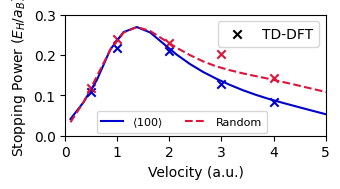

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ch, = ax.plot(velocities, stopping_power, color='mediumblue', label='Channel')
och, = ax.plot(velocities, stopping_power_random, '--', color='crimson', label='Off Channel')

# Add in the points for the channel
tddft = ax.scatter([], [], marker='x', facecolor='k', edgecolor='k', label='TD-DFT')
ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], marker='x',
                   facecolor='mediumblue', edgecolor='mediumblue', label='TD-DFT')
ax.scatter(random_stopping['velocity'], random_stopping['stopping'], marker='x',
                   facecolor='crimson', edgecolor='crimson', label='TD-DFT')

ax.set_xlabel('Velocity (a.u.)')
ax.set_ylabel('Stopping Power ($E_H / a_B$)')
ax.set_ylim(0, 0.3)
ax.set_xlim(0, 5)

l1 = ax.legend((ch, och), ('$\\left<100\\right>$', 'Random'), loc=(0.12, 0.02), ncol=2, fontsize=8)
ax.add_artist(l1)
ax.legend((tddft,), ('TD-DFT',))

fig.tight_layout()
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.png'), dpi=320)
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.pdf'))

*Finding*: The stopping power doesn't go to (0, 0), and does seem like it will converge to 0. But, the model does capture that the low velocity regime is linear and the difference between the channel and off chanell gets bigger at higher velocities before merging again at very high velocities.

Save the stopping power for the channels

In [ ]:
channel_stopping.to_csv('stopping_power-100.csv', index=False)